# Simulation of detector psf including detector gaps

Author: Carmen López Jurado

In [1]:
import sys
sys.path.insert(0,'./..')
sys.path.insert(0,'./../lib')

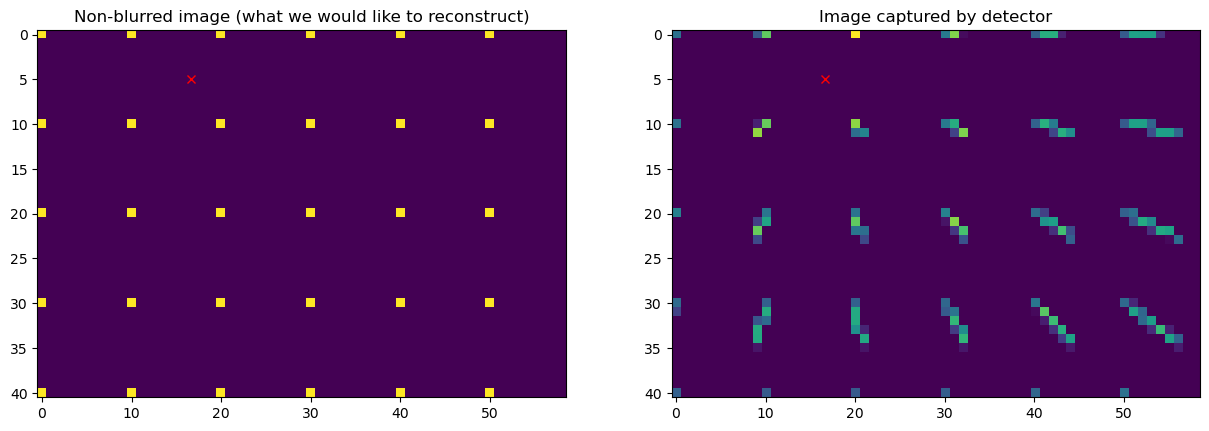

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import examplesetup
import lib.deconvolution as deconvolution
import lib.utils as utils
import lib.xtrace as xtrace

def comp_plots(left_plot, left_title, right_plot, right_title):
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    axs[0].imshow(left_plot)
    axs[0].set_title(left_title)
    axs[0].plot(*config["ray_origin"][:2][::-1], 'rx')
    
    axs[1].imshow(right_plot)
    axs[1].set_title(right_title)
    axs[1].plot(*config["ray_origin"][:2][::-1], 'rx')
    
    plt.show()

detector_scale = 50  #512

config = {
    "detector": {
            #number of (sub)modules per direction
            "nmods":(5,7),
            #number of pixels per module per direction
            "npixmod": (5, 5), 
            #electric correlation
            "el_corr": np.array([[0.5, 0.5, 0, 0],
                                 [0.5, 0.5, 0, 0], 
                                 [0, 0, 0.5, 0.5], 
                                 [0, 0, 0.5, 0.5]]),
            #pixel dimensions, WHICH ARE THE UNITS?
            "pixel_dims": (1.0, 1.0, 3.0),
            #energy absorbtion rate of detector material:
            "mu": 3.445930e-3
    },
    #ray origin position relative to upper left corner of detector:
    "ray_origin": np.array([detector_scale/10, detector_scale/3, detector_scale/3])        
}
config["detector"]["nvirpix"] = utils.nvirpix(config)
nvirpix = config["detector"]["nvirpix"]

#ray trace test with NO hardware 
#grid of rays that will hit the detector for estimating PSF
ray_grid = utils.ray_grid(config["detector"]["nvirpix"], 1)
#sparse matrix encoding the spatially variant PSF
G = xtrace.depth_spill_psf(config, *ray_grid)

#construct example image
img = np.zeros(nvirpix)
#img[70:80,50:60] = 1
#img[10:20, 70:80] = 1
img[::10,::10] = 1

#Apply the point spread function to our image
distorted_img_1 = (G.get()@img.flatten()).reshape(img.shape)

#plot example image and its point spread function
comp_plots(img, "Non-blurred image (what we would like to reconstruct)", 
           distorted_img_1, "Image captured by detector")

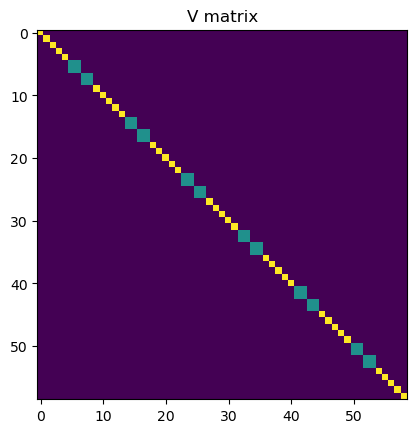

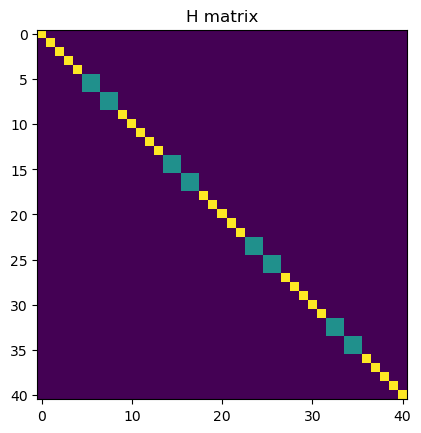

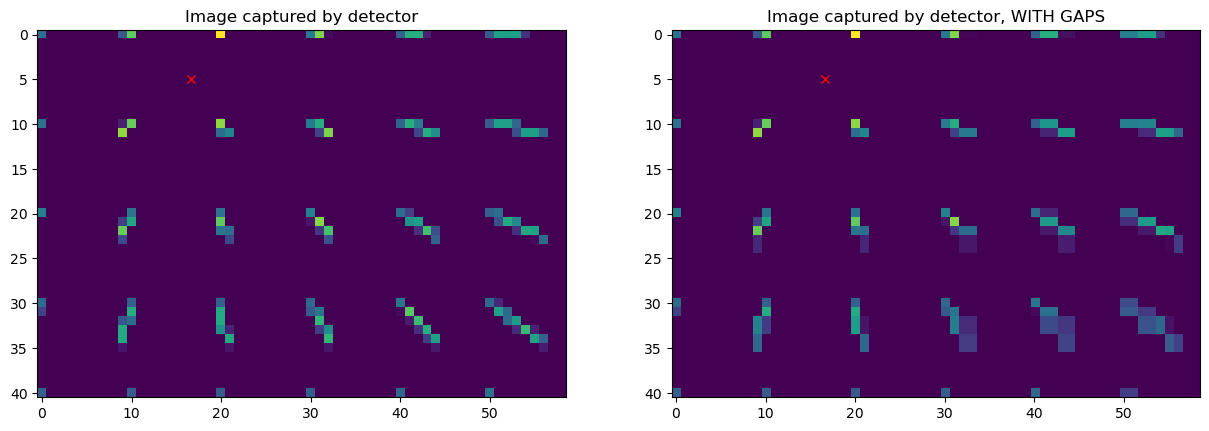

In [3]:
#same but now with hardware
#Transformation matrices
T, V, H = xtrace.gaps_psf(config)

#plt.imshow(T.get())
plt.imshow(V.get())
plt.title("V matrix")
plt.show()
plt.imshow(H.get())
plt.title("H matrix")
plt.show()

#Apply the point spread function to our image
distorted_img_2 = ((T@G).get()@img.flatten()).reshape(img.shape)
comp_plots(distorted_img_1, "Image captured by detector", 
           distorted_img_2, "Image captured by detector, WITH GAPS")

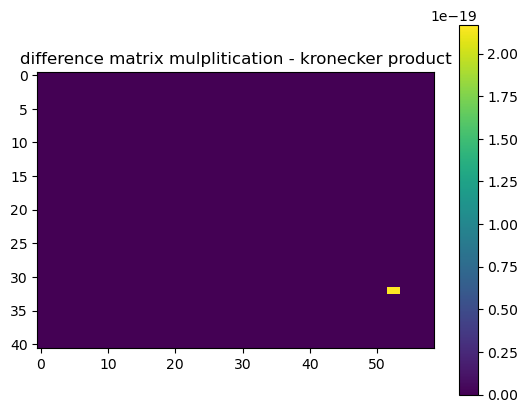

In [4]:
#checking that T is equivalent to H and V
distorted_img_3 = (H).get()@ (G.get()@img.flatten()).reshape(img.shape) @(V).get()
dif = np.abs(distorted_img_3 - distorted_img_2)
plt.imshow(dif)
plt.colorbar()
plt.title("difference matrix mulplitication - kronecker product")
plt.show()